## 46-886

## Classification Trees with Cross-Validation

### Application: Loan Default
 

Amr Farahat

CMU / Tepper

2023-03-18

---

-  0 denotes good risk (i.e. accept and issue load).
-  1 denotes bad risk (i.e. decline)

## Setting up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_graphviz
from graphviz import Source

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [4]:
pd.options.display.max_columns = None

In [5]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

## Importing data

In [6]:
df = pd.read_csv("loans.csv")

In [7]:
df

,default,installment,log_income,fico_score,rev_balance,inquiries,records
0,0,829,4.93,737,28.85,0,0
1,0,228,4.81,707,33.62,0,0
2,0,367,4.51,682,3.51,1,0
3,0,162,4.93,712,33.67,1,0
4,0,103,4.91,667,4.74,0,0
...,...,...,...,...,...,...,...
9511,1,345,5.29,672,215.37,2,0
9512,1,258,4.84,722,0.18,5,0
9513,1,98,4.60,687,10.04,8,0
9514,1,352,4.70,692,0.00,5,0


## Train / Test split

In [8]:
y = df["default"]
X = df.drop("default", axis=1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=886)

## Setting a classification threshold

In [10]:
mythreshold = 0.2

## Classification tree (max depth = 5; no CV)

In [11]:
treemod = DecisionTreeClassifier(max_depth=5, random_state=886)
treemod.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=886)

In [12]:
export_graphviz(
        treemod,
        out_file="loans_tree.dot",
        feature_names=X_train.columns,
        impurity=False,
        rounded=True,
        filled=True
    )

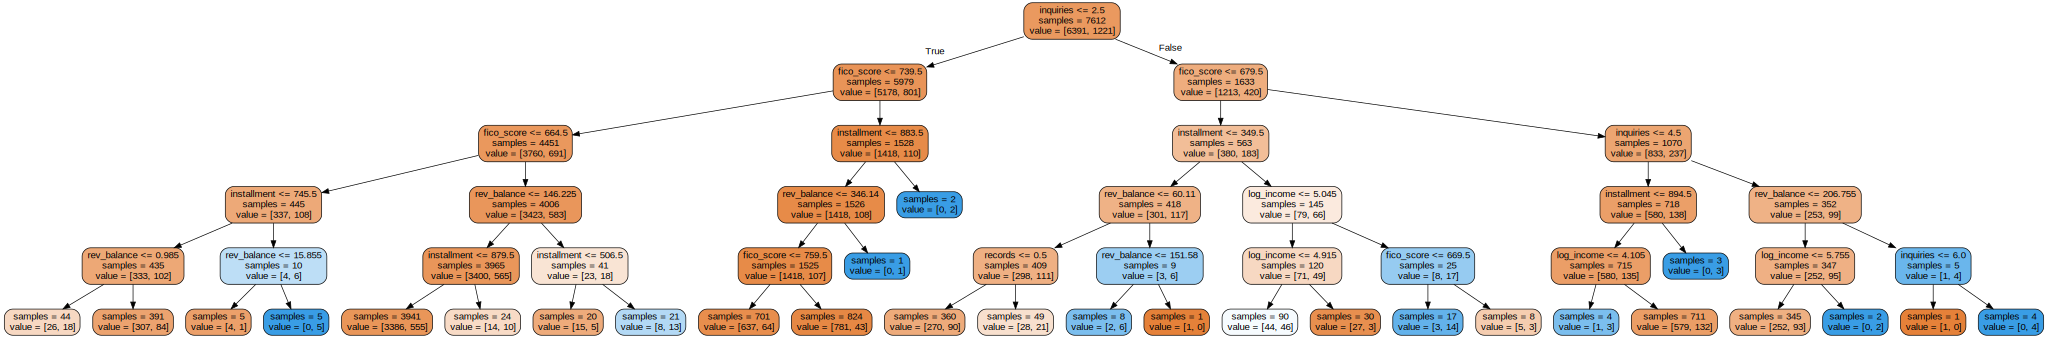

In [13]:
Source.from_file("loans_tree.dot")

Reference:
https://scikit-learn.org/stable/modules/tree.html#mathematical-formulation

In [14]:
treemod_pred_prob = treemod.predict_proba(X_test)

In [15]:
treemod_pred_prob

array([[0.8591728 , 0.1408272 ],
       [0.81434599, 0.18565401],
       [0.73043478, 0.26956522],
       ...,
       [0.8591728 , 0.1408272 ],
       [0.78516624, 0.21483376],
       [0.8591728 , 0.1408272 ]])

In [16]:
treemod_decisions = (treemod_pred_prob[:,1] >= mythreshold).astype(int)

In [17]:
treemod_cm = confusion_matrix(y_test, treemod_decisions)
treemod_cm

array([[1346,  258],
       [ 193,  107]], dtype=int64)

In [18]:
accuracy_score(y_test, treemod_decisions)

0.7631302521008403

In [19]:
fpr, tpr, thresholds = roc_curve(y_test, treemod_pred_prob[:,1])

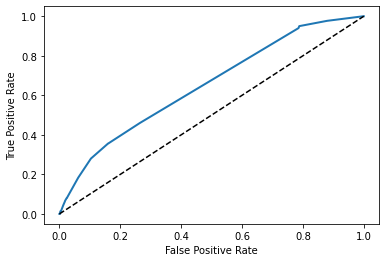

In [20]:
plot_roc_curve(fpr,tpr)
plt.show()

In [21]:
roc_auc_score(y_test, treemod_pred_prob[:,1])

0.6505746051537822

In [22]:
treemod_profit = (1000 * treemod_cm[0,0] - 4000 * treemod_cm[1,0] ) / sum(sum(treemod_cm))
treemod_profit

301.47058823529414

## Classification tree with CV

In [23]:
treemod.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 886,
 'splitter': 'best'}

In [24]:
param_grid = [
  {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]} 
]

In [25]:
cv_grid = GridSearchCV(treemod, param_grid, scoring="roc_auc")

In [26]:
cv_grid.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(max_depth=5, random_state=886),
             param_grid=[{'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]}],
             scoring='roc_auc')

In [27]:
pd.DataFrame(cv_grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003095,0.001682,0.001206,0.000756,2,{'max_depth': 2},0.618559,0.600141,0.619156,0.610457,0.622154,0.614093,0.007981,5
1,0.005016,0.000050,0.001240,0.000385,3,{'max_depth': 3},0.628775,0.609206,0.622499,0.601373,0.623195,0.617009,0.010121,3
2,0.006251,0.007656,0.000000,0.000000,4,{'max_depth': 4},0.634419,0.612411,0.626324,0.600078,0.635352,0.621717,0.013589,1
3,0.006389,0.005919,0.000000,0.000000,5,{'max_depth': 5},0.615840,0.607721,0.629029,0.603565,0.635127,0.618257,0.012111,2
4,0.009397,0.007673,0.000000,0.000000,6,{'max_depth': 6},0.638590,0.607191,0.618256,0.582618,0.626113,0.614553,0.018969,4
5,0.009500,0.007760,0.003149,0.006298,7,{'max_depth': 7},0.617491,0.610745,0.612676,0.579934,0.617979,0.607765,0.014188,6
6,0.009197,0.007105,0.000294,0.000588,8,{'max_depth': 8},0.601440,0.620838,0.606237,0.550216,0.617695,0.599285,0.025551,7
7,0.009462,0.006358,0.003125,0.006250,9,{'max_depth': 9},0.591760,0.613559,0.577944,0.554282,0.614315,0.590372,0.022670,8
8,0.009375,0.007655,0.003125,0.006250,10,{'max_depth': 10},0.601174,0.606817,0.561236,0.553242,0.586062,0.581706,0.021250,9


## 6.3. Retraining and assessing the final model

In [28]:
treemod_final = DecisionTreeClassifier(max_depth=4, random_state=886)
treemod_final.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=886)

In [29]:
export_graphviz(
        treemod_final,
        out_file="loans_tree_final.dot",
        feature_names=X_train.columns,
        impurity=False,
        rounded=True,
        filled=True
    )

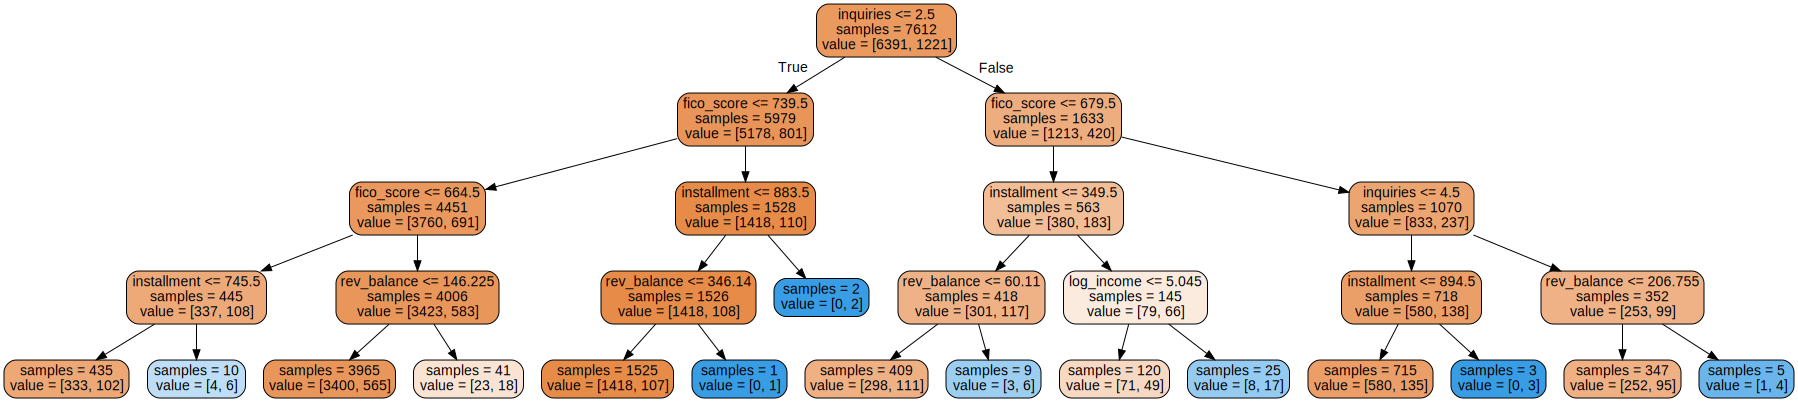

In [30]:
Source.from_file("loans_tree_final.dot")

Reference:
https://scikit-learn.org/stable/modules/tree.html#mathematical-formulation

In [31]:
treemod_final_pred_prob = treemod_final.predict_proba(X_test)

In [32]:
treemod_final_decisions = (treemod_final_pred_prob[:,1] >= mythreshold).astype(int)

In [33]:
treemod_final_cm = confusion_matrix(y_test, treemod_final_decisions)
treemod_final_cm

array([[1341,  263],
       [ 194,  106]], dtype=int64)

In [34]:
accuracy_score(y_test, treemod_final_decisions)

0.7599789915966386

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, treemod_final_pred_prob[:,1])

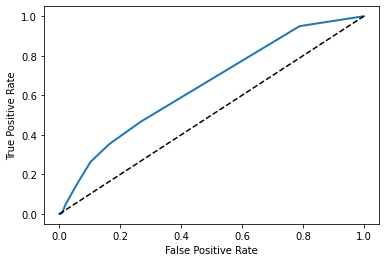

In [36]:
plot_roc_curve(fpr,tpr)
plt.show()

In [37]:
roc_auc_score(y_test, treemod_final_pred_prob[:,1])

0.649799459684123

In [38]:
treemod_final_profit = (1000 * treemod_final_cm[0,0] - 4000 * treemod_final_cm[1,0] ) / sum(sum(treemod_final_cm))
treemod_final_profit

296.7436974789916

### END